In [45]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from constants import EXTENSION_METHODS, RVSEC_ERRORS, REPETITIONS, TIMEOUTS, TOOLS, SUMMARY, METHOD_COVERAGE, \
    METHODS_JCA_COVERAGE, ACTIVITIES_COVERAGE

In [46]:
# TODO: copiar manualmente esses arquivos para a raiz de onde executa o notebook
results_file = "merged_results_analysis.json"
instrument_errors_file = "merged_instrument_errors.json"
# True se for o experimento com specs jca ... False se for o experimento com as novas specs
is_jca = True

# Totals

In [47]:
total_instrumented = 0
total_instrument_errors = 0

apks_with_errors = set()

with open(results_file, "r") as f:
    result = json.load(f)
    total_instrumented = len(result)
    for apk in result:
        for rep in result[apk][REPETITIONS]:
            for timeout in result[apk][REPETITIONS][rep][TIMEOUTS]:
                for tool in result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS]:
                    tool_result = result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS][tool]
                    errors = tool_result[RVSEC_ERRORS]
                    if len(errors) > 0:
                        apks_with_errors.add(apk)
                        continue
                    

with open(instrument_errors_file, "r") as f:
    result = json.load(f)
    total_instrument_errors = len(result)

total_experiment_apks = total_instrumented + total_instrument_errors
instrumented_pct = (total_instrumented * 100) / total_experiment_apks
apks_com_erros_pct = (len(apks_with_errors) * 100) / total_experiment_apks

print("FDROID: 4162")
print("TOTAL: {} (apks que usam jca)".format(total_experiment_apks))
print("INSTRUMENTADOS: {}".format(total_instrumented))
print("INSTRUMENTADOS (%): {}".format(instrumented_pct))
print("ERROS_INSTRUMENTACAO: {}".format(total_instrument_errors))
print("APKS_COM_ERROS_ENCONTRADOS: {}".format(len(apks_with_errors)))
print("APKS_COM_ERROS_ENCONTRADOS (%): {}".format(apks_com_erros_pct))

FDROID: 4162
TOTAL: 557 (apks que usam jca)
INSTRUMENTADOS: 193
INSTRUMENTADOS (%): 34.64991023339318
ERROS_INSTRUMENTACAO: 364
APKS_COM_ERROS_ENCONTRADOS: 88
APKS_COM_ERROS_ENCONTRADOS (%): 15.798922800718133


In [48]:
def parse_nova_spec(texto: str):
    s01 = texto.split(":::")
    tmp = s01[0].split("(")[0]

    last_dot_idx = tmp.rfind('.')
    clazz = tmp[:last_dot_idx].strip()
    method = tmp[last_dot_idx+1:].strip()

    a = s01[1].strip()
    spec = a.split(" ")[0].strip()
    msg = a.strip()

    return clazz, method, spec, msg

def parse_jca(texto: str):
    s01 = texto.split(",")
    spec = s01[0].strip()
    clazz = s01[1].strip()
    method = s01[3].strip()

    x = s01[4]
    idx = texto.rfind(x)
    msg = texto[idx+len(x)+1:].strip()

    return clazz, method, spec, msg

# Quantidade de erros por SPEC

Quantidade de SPECS que encontraram algum erro: 15
                       Spec  Cont  Errors
0            SSLContextSpec  4410       3
1         MessageDigestSpec  4343       7
2         SecretKeySpecSpec  1766       2
3                CipherSpec  1012       1
4              KeyStoreSpec   823       2
5       IvParameterSpecSpec   482       2
6          SecureRandomSpec   248       1
7                   MacSpec   182       1
8                PBEKeySpec   160       4
9   TrustManagerFactorySpec   154       2
10            SignatureSpec    63       1
11         PBEParameterSpec    40       2
12    KeyManagerFactorySpec    39       1
13              KeyPairSpec    20       1
14           PBEKeySpecSpec    20       1


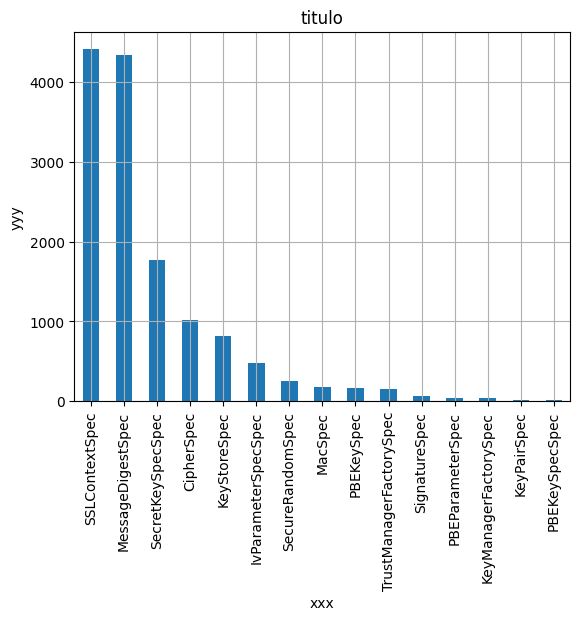

**** Erros unicos por spec:
                       Spec  Cont  Errors
0         MessageDigestSpec  4343       7
1                PBEKeySpec   160       4
2            SSLContextSpec  4410       3
3         SecretKeySpecSpec  1766       2
4              KeyStoreSpec   823       2
5       IvParameterSpecSpec   482       2
6   TrustManagerFactorySpec   154       2
7          PBEParameterSpec    40       2
8                CipherSpec  1012       1
9          SecureRandomSpec   248       1
10                  MacSpec   182       1
11            SignatureSpec    63       1
12    KeyManagerFactorySpec    39       1
13              KeyPairSpec    20       1
14           PBEKeySpecSpec    20       1
MessageDigestSpec (7)
	- InvalidSequenceOfMethodCalls,unknown
	- UnsafeAlgorithm,expecting one of {SHA-256, SHA-384, SHA-512} but found .
	- UnsafeAlgorithm,expecting one of {SHA-256, SHA-384, SHA-512} but found MD5.
	- UnsafeAlgorithm,expecting one of {SHA-256, SHA-384, SHA-512} but found SHA-1.
	-

In [49]:
with open(results_file, "r") as f:
    data = {}
    result = json.load(f)
    for apk in result:
        for rep in result[apk][REPETITIONS]:
            for timeout in result[apk][REPETITIONS][rep][TIMEOUTS]:
                for tool in result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS]:
                    tool_result = result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS][tool]
                    errors = tool_result[RVSEC_ERRORS]
                    for error in errors:
                        if is_jca:
                            clazz, method, spec, msg = parse_jca(error)
                        else:
                            clazz, method, spec, msg = parse_nova_spec(error)
                        
                        if spec not in data:
                            data[spec] = {"errors": set(),
                                         "total": 0}
                        data[spec]["total"] = data[spec]["total"] + 1
                        data[spec]["errors"].add(msg)

print("Quantidade de SPECS que encontraram algum erro: {}".format(len(data)))

specs_totals = []
for spec in data:
    specs_totals.append([spec, data[spec]["total"], len(data[spec]["errors"]) ])

df = pd.DataFrame(specs_totals, columns=['Spec', 'Cont', 'Errors'])
df = df.sort_values(by=['Cont'], ascending=False, ignore_index=True)
print(df)

df.plot(x="Spec", y='Cont', kind='bar', title='titulo', grid=True, xlabel="xxx", ylabel="yyy", legend=False)
plt.show()


print("**** Erros unicos por spec:")
df = df.sort_values(by=['Errors'], ascending=False, ignore_index=True)
print(df)
for ind in df.index:
    spec =  df['Spec'][ind]
    print("{} ({})".format(spec, len(data[spec]["errors"])))
    errors = sorted(list(data[spec]["errors"]))
    for err in errors:
        print("\t- {}".format(err))

# Quantidade de erros por APK

In [50]:
with open(results_file, "r") as f:
    data = {}
    result = json.load(f)
    for apk in result:
        if apk not in data:
            data[apk] = {"errors": set(),
                                         "total": 0}
        for rep in result[apk][REPETITIONS]:
            for timeout in result[apk][REPETITIONS][rep][TIMEOUTS]:
                for tool in result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS]:
                    tool_result = result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS][tool]
                    errors = tool_result[RVSEC_ERRORS]
                    for error in errors:
                        if is_jca:
                            clazz, method, spec, msg = parse_jca(error)
                        else:
                            clazz, method, spec, msg = parse_nova_spec(error)
               
                        data[apk]["total"] = data[apk]["total"] + 1
                        data[apk]["errors"].add(msg)

print("Quantidade de APKS que encontraram algum erro: {}".format(len(data)))

specs_totals = []
for spec in data:
    specs_totals.append([spec, data[spec]["total"], len(data[spec]["errors"]) ])

df = pd.DataFrame(specs_totals, columns=['Spec', 'Cont', 'Errors'])
df = df.sort_values(by=['Cont'], ascending=False, ignore_index=True)
print(df)

print("**** Erros unicos por APK:")
df = df.sort_values(by=['Errors'], ascending=False, ignore_index=True)
print(df)
for ind in df.index:
    spec =  df['Spec'][ind]
    print("{} ({})".format(spec, len(data[spec]["errors"])))
    errors = sorted(list(data[spec]["errors"]))
    for err in errors:
        print("\t- {}".format(err))

Quantidade de APKS que encontraram algum erro: 193
                                       Spec  Cont  Errors
0    org.mosad.seil0.projectlaogai_6000.apk  1634       6
1      io.github.domi04151309.home_1100.apk  1216       4
2           eu.bubu1.fdroidclassic_1110.apk   420       3
3        net.sf.andhsli.hotspotlogin_20.apk   400       3
4            fr.kwiatkowski.ApkTrack_24.apk   355       3
..                                      ...   ...     ...
188  com.soumikshah.investmenttracker_3.apk     0       0
189      com.Bisha.TI89EmuDonation_1133.apk     0       0
190     com.andybotting.tramhunter_1300.apk     0       0
191     com.aidinhut.simpletextcrypt_14.apk     0       0
192        net.momodalo.app.vimtouch_25.apk     0       0

[193 rows x 3 columns]
**** Erros unicos por APK:
                                            Spec  Cont  Errors
0         org.mosad.seil0.projectlaogai_6000.apk  1634       6
1                          com.akop.bach_120.apk   280       6
2        org.

### Erros por ferramenta/timeout

                     count    mean        std    min     25%    50%     75%  \
tool                                                                          
droidbot               4.0  110.75  14.818344   94.0  100.75  111.5  121.50   
droidbot_bfs_greedy    4.0  143.50  29.410882  100.0  139.00  155.0  159.50   
droidbot_bfs_naive     4.0  109.00  13.686977   89.0  107.00  113.5  115.50   
droidbot_dfs_greedy    4.0  145.75  29.398129  104.0  140.00  153.0  158.75   
droidmate              4.0  106.50  19.467922   78.0  102.00  114.5  119.00   
humanoid               4.0  160.25  26.625489  121.0  155.50  170.5  175.25   
monkey                 4.0  120.75   4.991660  117.0  117.75  119.0  122.00   

                       max  
tool                        
droidbot             126.0  
droidbot_bfs_greedy  164.0  
droidbot_bfs_naive   120.0  
droidbot_dfs_greedy  173.0  
droidmate            119.0  
humanoid             179.0  
monkey               128.0  


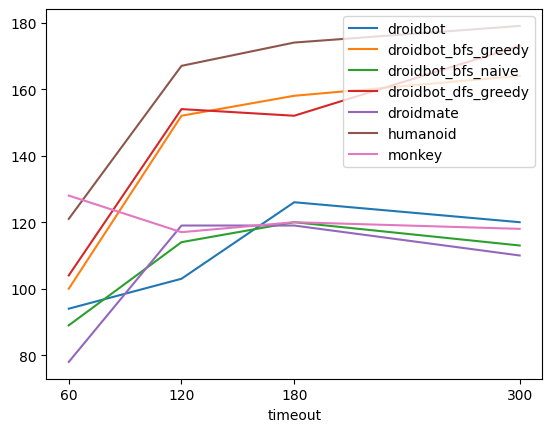

In [51]:
data = {}
with open(results_file, "r") as f:
    result = json.load(f)
    for apk in result:
        for rep in result[apk][REPETITIONS]:
            if rep not in data:
                data[rep] = {}
            for timeout in result[apk][REPETITIONS][rep][TIMEOUTS]:
                if timeout not in data[rep]:
                    data[rep][timeout] = {}
                for tool in result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS]:
                    if tool not in data[rep][timeout]:
                        data[rep][timeout][tool] = {"errors": set(), "total": 0}
                    tool_result = result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS][tool]
                    errors = tool_result[RVSEC_ERRORS]
                    for error in errors:
                        data[rep][timeout][tool]["total"] = data[rep][timeout][tool]["total"] + 1
                        data[rep][timeout][tool]["errors"].add(error)

tmp = []
for rep in data:
    for timeout in data[rep]:
        for tool in data[rep][timeout]:
            tmp.append([str(tool), int(rep), int(timeout), len(data[rep][timeout][tool]["errors"])])

df = pd.DataFrame(tmp, columns=['tool', 'rep', 'timeout', 'errors'])
df = df.sort_values(by=['timeout'], ascending=False, ignore_index=True)
# print(df)
# df.query("rep == 1 and tool == 'droidbot' ").plot(x="timeout", y=["errors"])

df.set_index('timeout', inplace=True)
# group data by tool and display errors as line chart
df = df.query("rep == 1").groupby('tool', group_keys=True)['errors']
print(df.describe())
# df = df.query("rep == '1'").groupby(['timeout'],  group_keys=True)['errors']
df.plot(legend=True)
plt.xticks([60, 120, 180, 300])
plt.show()


#df = pd.DataFrame(tmp, columns=['tool', 'rep', 'timeout', 'errors'])
#df = df.sort_values(by=['timeout'], ascending=False, ignore_index=True)
#pd.pivot_table(df.reset_index(),
#                index='timeout', columns='rep', values='errors'
#                ).plot(subplots=True)
#plt.xticks([60, 120, 180, 300])
#plt.show()

# FDROID

In [52]:
from csv import DictReader

def read_fdroid(planilha_fdroid_path):
    apps = {}
    with open(planilha_fdroid_path, 'r') as f:
        dict_reader = DictReader(f)
        list_of_dict = list(dict_reader)
        for app in list_of_dict:
            app['mop'] = False if app['mop'] == 'No' else True
            app['package'] = False if app['package'] == 'False' else True

            apps[app['file']] = app
    return apps

### Aplicativos que usam o mesmo pacote declarado no manifest

In [58]:
planilha_fdroid_path = "fdroid/final_apps_to_download.csv"

cont_same_package = 0

fdroid = read_fdroid(planilha_fdroid_path)

for apk in fdroid:    
    if fdroid[apk]['package']:
        cont_same_package += 1

print("TOTAL APKS: {}".format(total_experiment_apks))
print("APKS_SAME_PACKAGE: {}".format(cont_same_package))

pct = (cont_same_package * 100) / total_experiment_apks
print("APKS_SAME_PACKAGE (%): {}".format(pct))


#apenas s instrumentados
cont_same_package = 0
with open(results_file, "r") as f:
    result = json.load(f)
    for apk in result:
        if fdroid[apk]['package']:
            cont_same_package += 1

print("APKS_INSTRUMENTADOS_SAME_PACKAGE: {}".format(cont_same_package))
pct = (cont_same_package * 100) / total_instrumented
print("APKS_INSTRUMENTADOS_SAME_PACKAGE (%): {}".format(pct))
        
    

TOTAL APKS: 557
APKS_SAME_PACKAGE: 498
APKS_SAME_PACKAGE (%): 89.40754039497307
APKS_INSTRUMENTADOS_SAME_PACKAGE: 172
APKS_INSTRUMENTADOS_SAME_PACKAGE (%): 89.11917098445596


# Cobertura

### Media total de coberturas ...

In [60]:
activity = []
method = []
mop = []
with open(results_file, "r") as f:
    result = json.load(f)
    for apk in result:
        for rep in result[apk][REPETITIONS]:
            for timeout in result[apk][REPETITIONS][rep][TIMEOUTS]:
                for tool in result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS]:
                    summary = result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS][tool][SUMMARY]
                    activity.append(summary[ACTIVITIES_COVERAGE])
                    method.append(summary[METHOD_COVERAGE])
                    mop.append(summary[METHODS_JCA_COVERAGE])
print("ATIVIDADE: {}".format(np.mean(np.array(activity))))                    
print("METODO: {}".format(np.mean(np.array(method)))) 
print("METODO_JCA: {}".format(np.mean(np.array(mop)))) 

ATIVIDADE: 35.26212626622186
METODO: 14.50417980658017
METODO_JCA: 8.388436549058312


### Media de cobertura por aplicativo

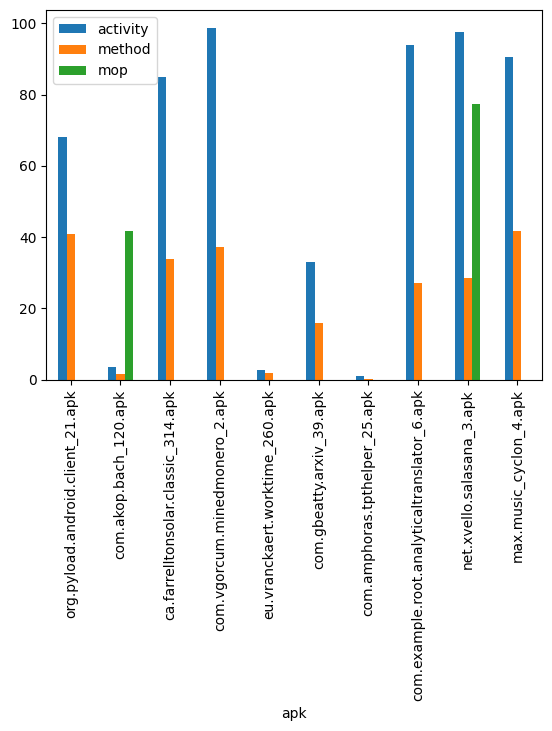

In [55]:
data = {}
with open(results_file, "r") as f:
    result = json.load(f)
    for apk in result:
        data[apk] = {'activity': [],
                     'method': [],
                     'mop': []}
        for rep in result[apk][REPETITIONS]:
            for timeout in result[apk][REPETITIONS][rep][TIMEOUTS]:
                for tool in result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS]:
                    summary = result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS][tool][SUMMARY]
                    data[apk]['activity'].append(summary[ACTIVITIES_COVERAGE])
                    data[apk]['method'].append(summary[METHOD_COVERAGE])
                    data[apk]['mop'].append(summary[METHODS_JCA_COVERAGE])
coverage_by_apk = []
for apk in data:
    coverage_by_apk.append([apk, np.mean(np.array(data[apk]['activity'])), np.mean(np.array(data[apk]['method'])), np.mean(np.array(data[apk]['mop']))])

df = pd.DataFrame(coverage_by_apk, columns=['apk', 'activity', 'method', 'mop'])

df = df.sort_values(by=['activity'], ascending=False, ignore_index=True)
# print(df)

# df.plot()
# df["activity"].plot(kind='hist')
# df.plot(x="apk", y=['activity', 'method', 'mop'])
df.query('activity > 0').sample(n=10).plot(x="apk", y=['activity', 'method', 'mop'], kind='bar')

plt.show()

In [ ]:
### Media de cobertura por ferramenta

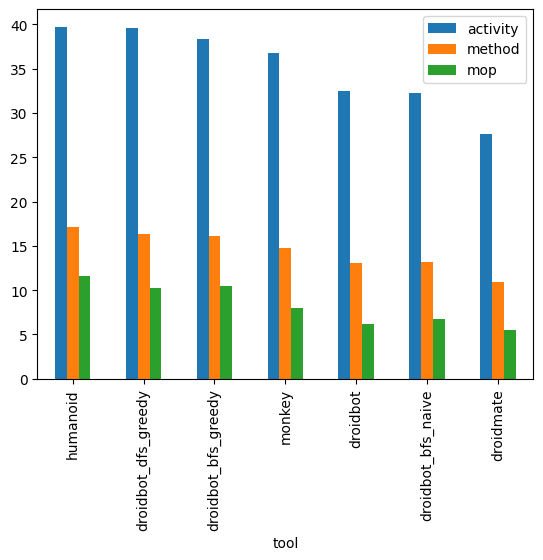

In [65]:
data = {}
with open(results_file, "r") as f:
    result = json.load(f)
    for apk in result:        
        for rep in result[apk][REPETITIONS]:
            for timeout in result[apk][REPETITIONS][rep][TIMEOUTS]:
                for tool in result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS]:
                    if tool not in data:
                        data[tool] = {'activity': [],
                         'method': [],
                         'mop': []}
                    summary = result[apk][REPETITIONS][rep][TIMEOUTS][timeout][TOOLS][tool][SUMMARY]
                    data[tool]['activity'].append(summary[ACTIVITIES_COVERAGE])
                    data[tool]['method'].append(summary[METHOD_COVERAGE])
                    data[tool]['mop'].append(summary[METHODS_JCA_COVERAGE])
coverage_by_apk = []
for tool in data:
    coverage_by_apk.append([tool, np.mean(np.array(data[tool]['activity'])), np.mean(np.array(data[tool]['method'])), np.mean(np.array(data[tool]['mop']))])

df = pd.DataFrame(coverage_by_apk, columns=['tool', 'activity', 'method', 'mop'])

df = df.sort_values(by=['activity'], ascending=False, ignore_index=True)
#print(df)

df.plot(x="tool", y=['activity', 'method', 'mop'], kind='bar')

plt.show()